In [18]:
import warnings
warnings.filterwarnings('ignore')

import os
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'Malgun Gothic'

# Final Method
- period = 24로 설정이 타당한 이유: 
    - 어찌 되었던, 24의 배수로 seasonal pattern 존재할 것 
    - 현재 trend 의 모양을 봐서는 seasonal component가 제대로 안잡아내는거라고 할 수 있는데
    - residual component 를 보면 그래도 준수한 편( constant variance, no trend, mean around 0) 
- 약점:
    - residual component에 약간 주기성을 띄는 data point 들이 보이지만.. 

In [1]:
"""
- library load 
- data load 
- data subsetting by 공급사
"""

import os
os.getcwd()
os.chdir('C:\\Users\\user\\Desktop\\Gas_Prediction')
os.listdir()

import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.special import inv_boxcox
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import STL



# 데이터 로드 및 구성보기  
train = pd.read_csv('./data/train.csv', index_col = 0)
train.index = pd.DatetimeIndex(train.index)
test = pd.read_csv('data/test.csv', index_col = 0)
test.index = pd.DatetimeIndex(test.index)
#------------------------------------------------------------------------------

In [3]:
## 공급사별 dct 나누기
comp_lst = ['A', 'B', 'C', 'D', 'E', 'G', 'H']
comp_dct = {name : pd.DataFrame() for name in comp_lst}

"""
- 공급사별 대체 시행
"""
for cp in comp_lst:
  comp_dct[cp] = train.query(f"구분 == '{cp}'")
## 공급사별 outlier detection 및 대체 시행
for comp in comp_lst:
    y = np.log(comp_dct[comp]['공급량'])
    stl = STL(y, period = 24)
    res = stl.fit()
    
    ## traking 위해서 log 변환 후 stl decomp 한 결과 저장
    comp_dct[comp]['lg_trend'] = res.trend
    comp_dct[comp]['lg_seasonal'] = res.seasonal
    comp_dct[comp]['lg_resid'] = res.resid
    comp_dct[comp]['exp_resid'] = np.exp(res.resid)

    exp_resid = np.exp(res.resid)
    exp_mean =exp_resid.mean()
    exp_std = exp_resid.std()
    
    lg_resid = res.resid
    lg_mean = lg_resid.mean()
    lg_std = lg_resid.std()
    
    ## outlier flag 생성
    comp_dct[comp]['exp_flag'] = np.where(np.abs((exp_resid-exp_mean)/exp_std)>=6 ,1 , 0)
    comp_dct[comp]['lg_flag'] = np.where(np.abs((lg_resid-lg_mean)/lg_std)>=6 ,1 , 0)

    
    ## new residual 생성
    comp_dct[comp]['new_exp_resid'] = np.where(np.abs((exp_resid-exp_mean)/exp_std)>6 ,exp_mean, exp_resid)
    comp_dct[comp]['new_lg_resid'] = np.where(np.abs((lg_resid-lg_mean)/lg_std)>6 ,lg_mean, lg_resid)    
    
    
    comp_dct[comp]['new_lg_resid_or'] = np.exp(comp_dct[comp]['new_lg_resid'])
    ## new supply 생성
    comp_dct[comp]['exp_new_supply'] = np.exp(res.trend + res.seasonal) * comp_dct[comp]['new_exp_resid'] 
    comp_dct[comp]['lg_new_supply'] = np.exp(res.trend + res.seasonal + comp_dct[comp]['new_lg_resid'])
    
### test 용  
"""test = np.log(comp_dct['A']['공급량'])
stl=STL(test, period = 24, robust = True)
res = stl.fit()
test_df = pd.DataFrame(res.trend)"""


"test = np.log(comp_dct['A']['공급량'])\nstl=STL(test, period = 24, robust = True)\nres = stl.fit()\ntest_df = pd.DataFrame(res.trend)"

A 공급사 ======================================
lg outlier 개수: 8 개
exp outlier 개수: 9 개


B 공급사 ======================================
lg outlier 개수: 38 개
exp outlier 개수: 37 개


C 공급사 ======================================
lg outlier 개수: 326 개
exp outlier 개수: 193 개


D 공급사 ======================================
lg outlier 개수: 74 개
exp outlier 개수: 49 개


E 공급사 ======================================
lg outlier 개수: 9 개
exp outlier 개수: 10 개


G 공급사 ======================================
lg outlier 개수: 13 개
exp outlier 개수: 15 개


H 공급사 ======================================
lg outlier 개수: 58 개
exp outlier 개수: 22 개




Text(0.5, 0.98, 'Logged 대체 전 후 resid 비교')

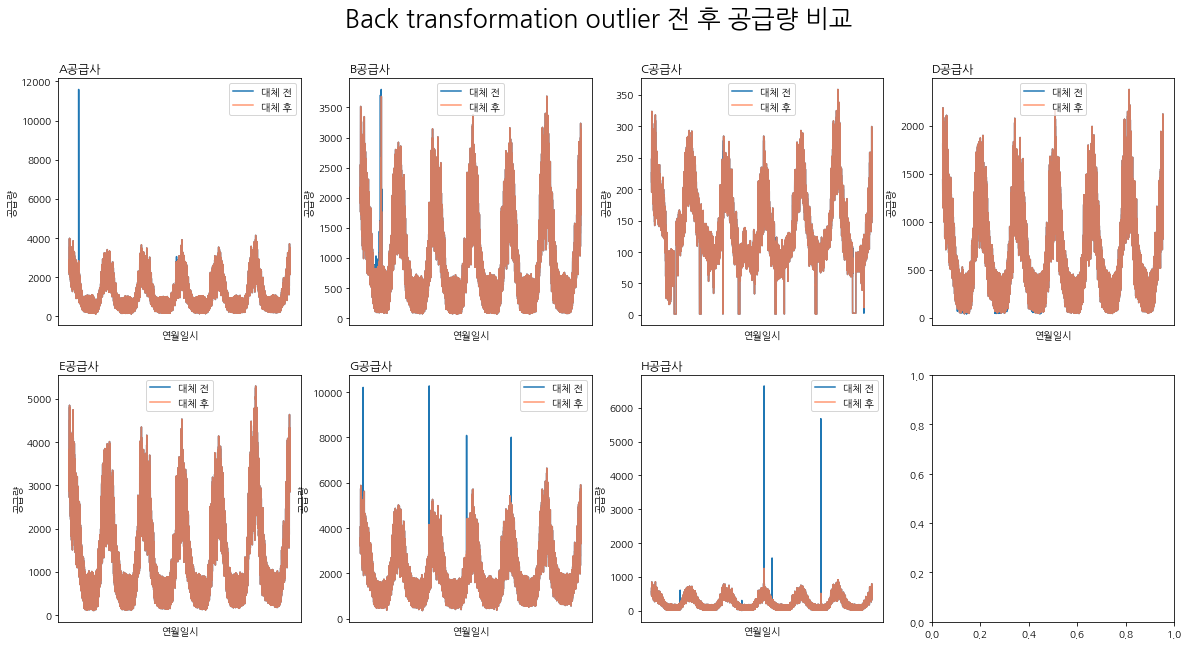

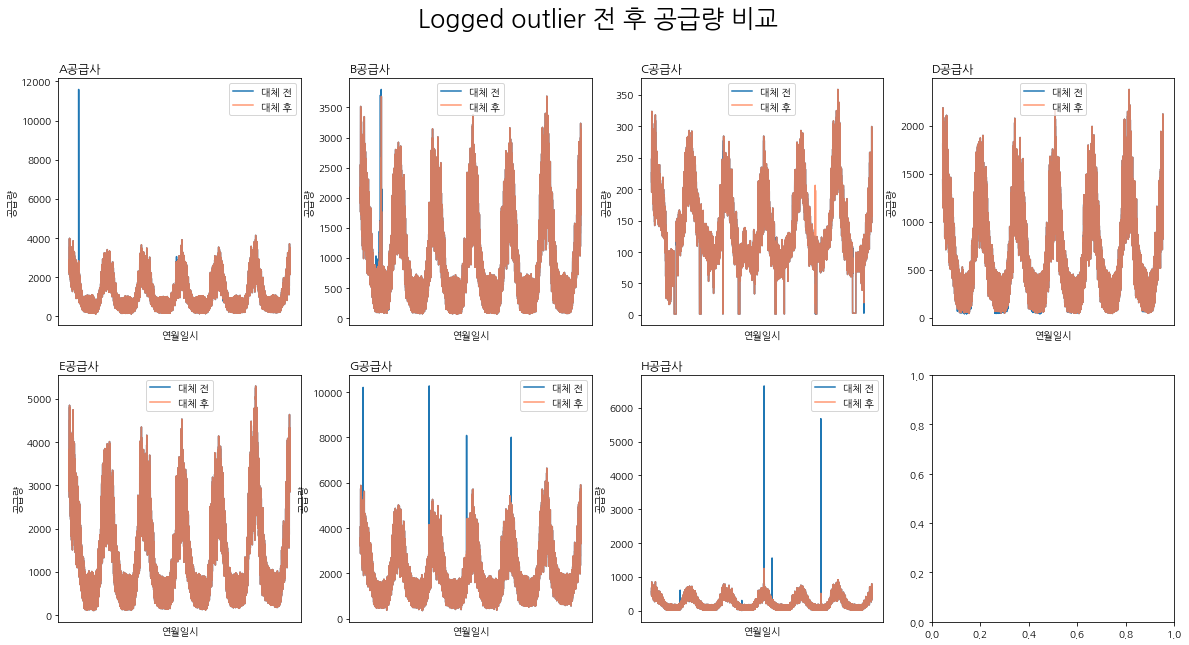

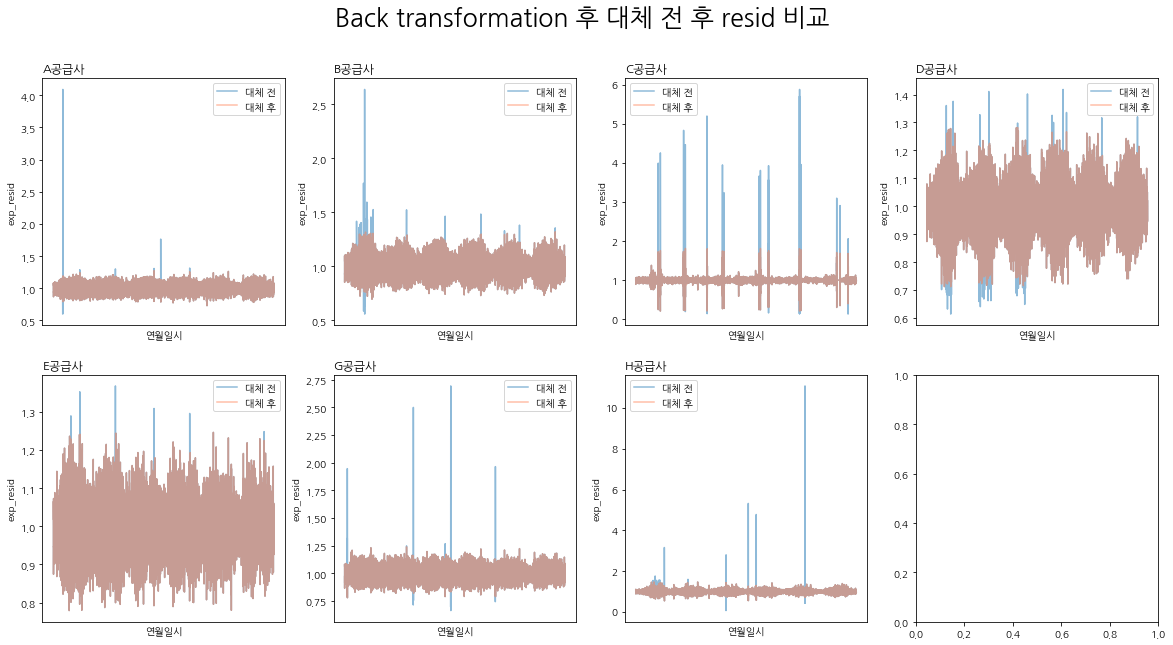

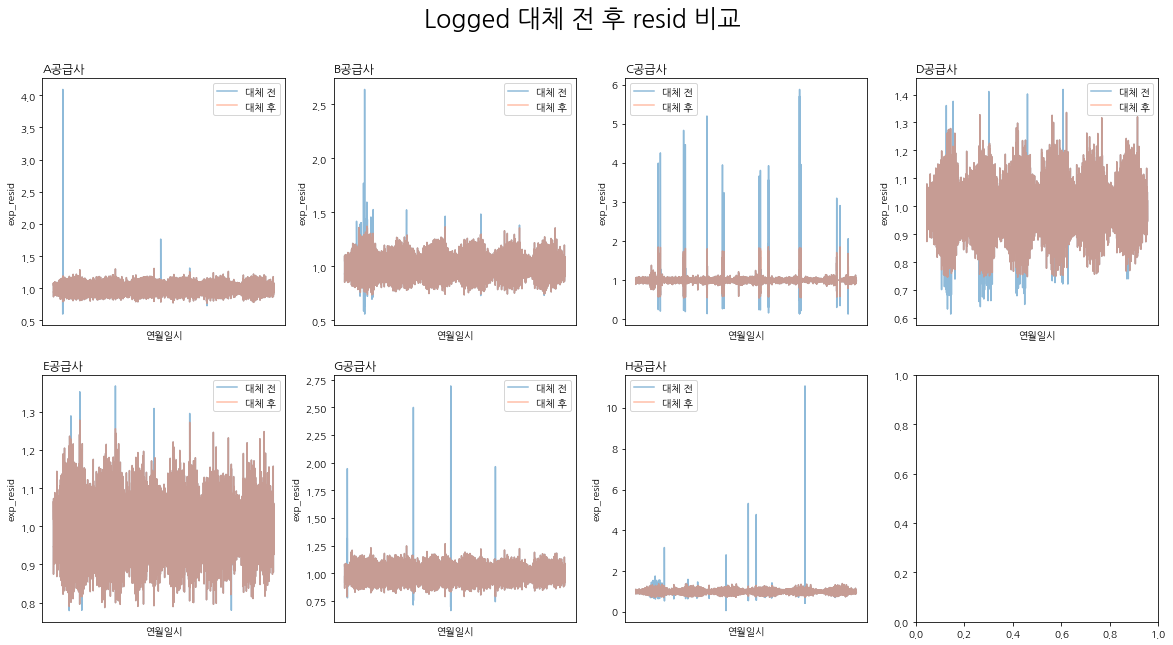

In [5]:
"""
- 공급사 별 대체 결과 확인 및 시각화
"""
for comp in comp_lst:
    print(f"{comp} 공급사 ======================================")
    print(f"lg outlier 개수: {comp_dct[comp]['lg_flag'].sum()} 개")
    print(f"exp outlier 개수: {comp_dct[comp]['exp_flag'].sum()} 개")
    print("\n")
    
### 최종 공급량 비교    
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (20,10))
ax = ax.reshape(8)

for idx, comp in enumerate(comp_lst):
    sns.lineplot(data = comp_dct[comp]['공급량'], label = "대체 전",  ax =ax[idx])
    sns.lineplot(data = comp_dct[comp]['exp_new_supply'], label = '대체 후', color = 'coral', alpha = 0.8, ax = ax[idx])
    ax[idx].set_title(f"{comp}공급사", loc = 'left')
    ax[idx].legend()
    ax[idx].set_xticks([])
plt.suptitle('Back transformation outlier 전 후 공급량 비교', fontsize = 25)



fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (20,10))
ax = ax.reshape(8)

for idx, comp in enumerate(comp_lst):
    sns.lineplot(data = comp_dct[comp]['공급량'], label = "대체 전",  ax =ax[idx])
    sns.lineplot(data = comp_dct[comp]['lg_new_supply'], label = '대체 후', color = 'coral', ax = ax[idx], alpha = 0.8)
    ax[idx].set_title(f"{comp}공급사", loc = 'left')
    ax[idx].legend()
    ax[idx].set_xticks([])
plt.suptitle('Logged outlier 전 후 공급량 비교', fontsize = 25)
### resid 만 비교
### back -transformation 후 outlier detection

fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (20,10))
ax = ax.reshape(8)

for idx, comp in enumerate(comp_lst):
    sns.lineplot(data = comp_dct[comp]['exp_resid'], label = "대체 전", alpha = 0.5, ax = ax[idx])
    sns.lineplot(data = comp_dct[comp]['new_exp_resid'], label = '대체 후', alpha=0.5, ax = ax[idx], color = 'coral')
    ax[idx].set_title(f"{comp}공급사", loc = 'left')
    ax[idx].legend()
    ax[idx].set_xticks([])
plt.suptitle('Back transformation 후 대체 전 후 resid 비교', fontsize = 25)


### logged  outlier detection
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (20,10))
ax = ax.reshape(8)

for idx, comp in enumerate(comp_lst):
    sns.lineplot(data = comp_dct[comp]['exp_resid'], label = "대체 전", alpha = 0.5, ax = ax[idx])
    sns.lineplot(data = comp_dct[comp]['new_lg_resid_or'], label = '대체 후', alpha=0.5, ax = ax[idx], color = 'coral')
    ax[idx].set_title(f"{comp}공급사", loc = 'left')
    ax[idx].legend()
    ax[idx].set_xticks([])
plt.suptitle('Logged 대체 전 후 resid 비교', fontsize = 25)


In [ ]:
### 저장 
for comp in comp_lst:
    comp_dct[comp].to_csv(f"./data/{comp}공급사_train.csv")
os.listdir('./data')


new_train = pd.DataFrame(columns = comp_dct['A'].columns)
for comp in comp_lst:
    new_train = new_train.append(comp_dct[comp])

new_train.to_csv('./data/new_train.csv')

# 1. 데이터 준비
## 1) Train Data

In [3]:
# 데이터 load
raw_train= pd.read_csv('./data/한국가스공사_시간별 공급량_20181231.csv', encoding='cp949')
raw_train.head(25)

,연월일,시간,구분,공급량
0,2013-01-01,1,A,2497.129
1,2013-01-01,2,A,2363.265
2,2013-01-01,3,A,2258.505
3,2013-01-01,4,A,2243.969
4,2013-01-01,5,A,2344.105
5,2013-01-01,6,A,2390.961
6,2013-01-01,7,A,2378.457
7,2013-01-01,8,A,2518.921
8,2013-01-01,9,A,2706.481
9,2013-01-01,10,A,2832.057


In [4]:
# 데이터 자료형 전처리
# 구분 확인
raw_train['구분'].unique()

# string object -> datetime 
raw_train['연월일'] = pd.to_datetime(raw_train['연월일'], format = '%Y-%m-%d')

# datetime + 시간 
## 시간 int -> flaot (datetime 더하기 할려면 필요)
raw_train = raw_train.astype({'시간':'float64'})
raw_train['연월일시'] = [raw_train['연월일'][i]+ timedelta(hours = raw_train['시간'][i]-1) for i in range(len(raw_train))]
#print(raw_df.head())
raw_train.to_csv("./data/raw_train.csv")
'''
# 연월일시 나눠서 컬럼 생성
raw_df['year'] = [raw_df['연월일시'][i].year for i in range(len(raw_df))]
raw_df['month'] = [raw_df['연월일시'][i].month for i in range(len(raw_df))]
raw_df['day'] = [raw_df['연월일시'][i].day for i in range(len(raw_df))]
raw_df['hour'] = [raw_df['연월일시'][i].hour for i in range(len(raw_df))]
#print(raw_df.tail())
'''
#raw_train

df = raw_train.set_index(raw_train['연월일시']).loc[:, ['구분', '공급량']]
df

,구분,공급량
연월일시,,
2013-01-01 00:00:00,A,2497.129
2013-01-01 01:00:00,A,2363.265
2013-01-01 02:00:00,A,2258.505
2013-01-01 03:00:00,A,2243.969
2013-01-01 04:00:00,A,2344.105
...,...,...
2018-12-31 19:00:00,H,681.033
2018-12-31 20:00:00,H,669.961
2018-12-31 21:00:00,H,657.941


# 2. Preprocessing
## 1) Transformation using BoxCox

In [7]:
# 공급사별 numerical statistics
comp_lst = ['A', 'B', 'C', 'D', 'E', 'G', 'H']
comp_dct = {name : pd.DataFrame() for name in comp_lst}

for cp in comp_lst:
  comp_dct[cp] = df.query(f"구분 == '{cp}'")

In [10]:
# D 공급사 먼저 
df_D = comp_dct['D']['공급량']

In [11]:
lg_df_D = stats.boxcox(df_D)[0]
lg_df_D = pd.Series(lg_df_D)
lg_df_D.index = df_D.index

## 2) STL Decomposition

Text(0.5, 1.05, 'Transformed, period = 24, robust')

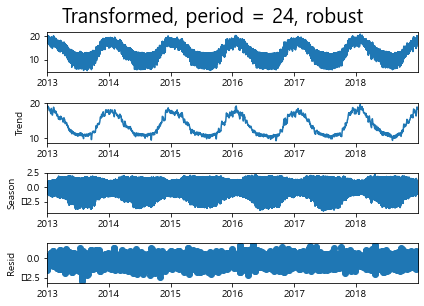

In [15]:
# Naive STL Decomposition
stl = STL(lg_df_D, period = 24, robust = True)
res = stl.fit()
fig = res.plot()
plt.suptitle("Transformed, period = 24, robust", fontsize = 20, y =1.05)

In [19]:
# Result of decomposition test -> residual 정규성 검사
residual_A = res.resid
# shapiro test
sha_stat, sha_p = stats.shapiro(residual_A)
print("=="*50)
print("<The result of Shaprio Test>")
if sha_p < 0.05:
    print(f"  Test statistic: {sha_stat}, p-value: {sha_p:.9f}, therefore, reject the null ")
else:
    print(f"Test statistic: {sha_stat}, p-value: {sha_p}, therefore, fail to reject the null")

# D'Agostino's k^2 Test
k2_stat, k2_p = stats.normaltest(residual_A)
print("=="*50)
print("<The result of D'Agostino's K^2 Test>")
if k2_p < 0.05:
    print(f"  Test statistic: {k2_stat}, p-value: {k2_p:.9f}, therefore, reject the null ")
else:
    print(f"Test statistic: {k2_stat}, p-value: {k2_p}, therefore, fail to reject the null")
    
# Augmented Dickey-Fuller test
result = adfuller(residual_A)
print("=="*50)
print("<The result of Dickey-Fuller Test>")
if result[1] < 0.05:
    print(f"Test statistic: {result[0]}, p-value: {result[1]:.9f}, therefore, rejet the null=stationary")
else:
    print(f"Test statistic: {result[0]}, p-value: {result[1]:.9f}, therefore, fail to rejet the null=stationary")

<The result of Shaprio Test>
  Test statistic: 0.7737036943435669, p-value: 0.000000000, therefore, reject the null 
<The result of D'Agostino's K^2 Test>
  Test statistic: 20664.394304777517, p-value: 0.000000000, therefore, reject the null 
<The result of Dickey-Fuller Test>
Test statistic: -32.352279347311516, p-value: 0.000000000, therefore, rejet the null=stationary


# 3. Outlier Detection using 6 Sigma

In [17]:
# 기준 = 6 outlier dectection
threshold = 6

outlier_D = [] 
mean = res.resid.mean()
std = res.resid.std()

for i in res.resid: 
    z = (i-mean)/std 
    if np.abs(z) > threshold: 
        outlier_D.append(i) 

print('데이터셋 내의 이상값', len(outlier_D), '개') 
print("====="*20)
print(outlier_D)

데이터셋 내의 이상값 35 개
[-1.9243748961390281, -2.422619397504258, -2.255506384204173, -2.3001581040129206, -2.2398192741903955, -2.2754659641465675, -2.620731007144917, -2.933607102779968, -2.6961835708915007, -2.531690588143853, -1.8580461273061477, -1.9174453426644895, -2.19745280020431, -2.0267064106276873, -1.8982116680721823, -1.8588458357635407, -1.987380289859713, -1.9932679920888088, -2.1467531515741047, -1.8499359016322394, -1.9553984037545806, -2.0936474157228275, -2.364651742437797, -2.002743575747214, -1.8451273082083137, -1.8371772452800563, -1.8529825680020195, -2.02420374644084, -2.112623767155201, -1.9335434759280172, 1.7213422825555682, -1.9533859484889664, -1.9045241115557872, -1.9865638219548831, 1.7055765995667738]


###  Index 뽑아내기

In [21]:
# outlier index 뽑아내기 
test1 = res.resid

outlier_D_index = [test1[test1 == item] for item in outlier_D]
outlier_D_index

[연월일시
 2013-04-14 06:00:00   -1.924375
 Name: resid, dtype: float64,
 연월일시
 2013-07-24 09:00:00   -2.422619
 Name: resid, dtype: float64,
 연월일시
 2013-07-24 10:00:00   -2.255506
 Name: resid, dtype: float64,
 연월일시
 2013-07-24 11:00:00   -2.300158
 Name: resid, dtype: float64,
 연월일시
 2013-07-24 12:00:00   -2.239819
 Name: resid, dtype: float64,
 연월일시
 2013-07-24 13:00:00   -2.275466
 Name: resid, dtype: float64,
 연월일시
 2013-07-24 14:00:00   -2.620731
 Name: resid, dtype: float64,
 연월일시
 2013-07-24 15:00:00   -2.933607
 Name: resid, dtype: float64,
 연월일시
 2013-07-24 16:00:00   -2.696184
 Name: resid, dtype: float64,
 연월일시
 2013-07-24 17:00:00   -2.531691
 Name: resid, dtype: float64,
 연월일시
 2013-08-12 02:00:00   -1.858046
 Name: resid, dtype: float64,
 연월일시
 2013-08-26 01:00:00   -1.917445
 Name: resid, dtype: float64,
 연월일시
 2013-08-26 02:00:00   -2.197453
 Name: resid, dtype: float64,
 연월일시
 2013-09-02 01:00:00   -2.026706
 Name: resid, dtype: float64,
 연월일시
 2014-05-25 07:00:00   -1.89

### np.where 로 한번에 flag 컬럼 만들기

In [24]:
df_D=comp_dct['D']

In [25]:
# residual column
df_D['resid'] = test1

# flag column 생성
df_D['flag4'] =  np.where(np.abs((df_D['resid']- mean)/std ) > 6 , 1, 0)
df_D['flag4'].sum() # outlier 개수 확인


35

In [26]:
df_D

,구분,공급량,resid,flag4
연월일시,,,,
2013-01-01 00:00:00,D,1434.516,-0.347144,0
2013-01-01 01:00:00,D,1345.636,-0.069187,0
2013-01-01 02:00:00,D,1270.756,-0.120086,0
2013-01-01 03:00:00,D,1322.036,-0.411404,0
2013-01-01 04:00:00,D,1421.956,-0.503510,0
...,...,...,...,...
2018-12-31 19:00:00,D,1835.411,0.009755,0
2018-12-31 20:00:00,D,1767.964,-0.012680,0
2018-12-31 21:00:00,D,1720.595,-0.001132,0
